# Image classifier project

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
import numpy as np
import matplotlib.pyplot as plt
from tensorflow import keras
from keras.preprocessing import image

2025-03-04 15:55:26.048793: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-04 15:55:26.349965: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-04 15:55:27.063120: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-04 15:55:27.065151: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-04 15:55:28.319732: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

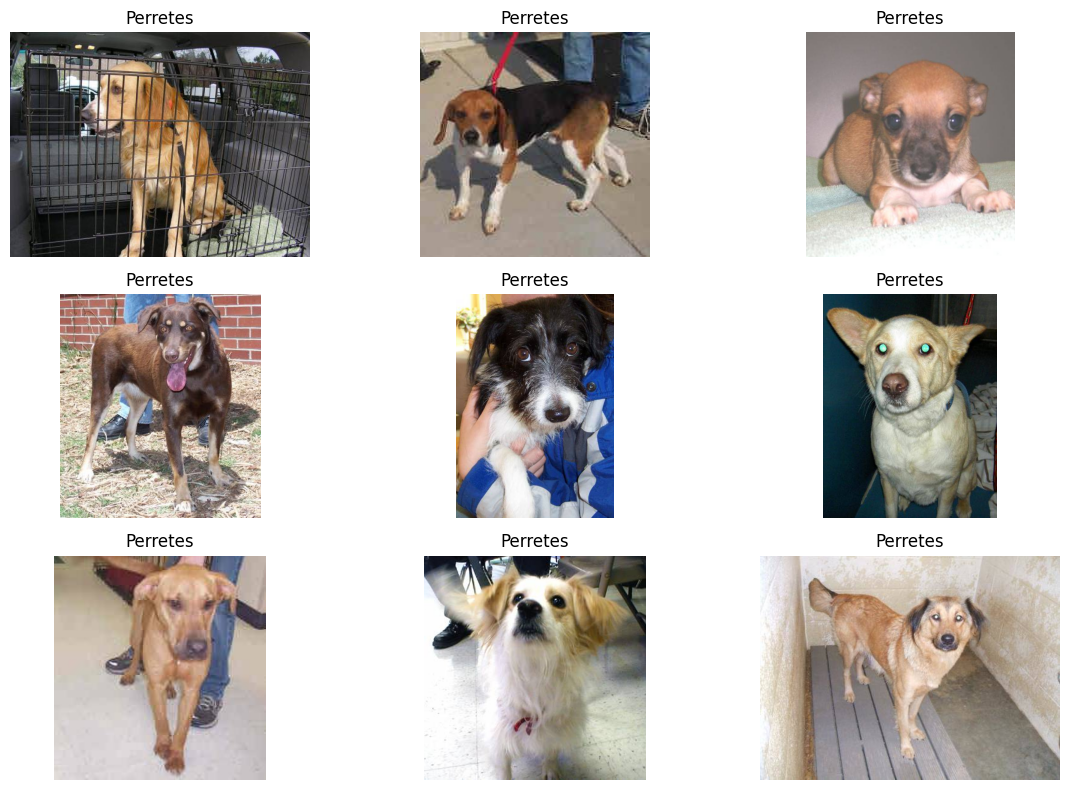

In [4]:
import os
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image

# Path
dog_dir = "../data/raw/train/dog"

#Filtro
dog_image_files = [f for f in os.listdir(dog_dir) if f.startswith("dog")]

dog_images = []
for i in range(min(9, len(dog_image_files))):  #Control numeración imagenes
    img_path = os.path.join(dog_dir, dog_image_files[i])
    img = image.load_img(img_path)  # Carga
    img_array = image.img_to_array(img) / 255.0  # Conversion a array
    dog_images.append(img_array)


plt.figure(figsize=(12, 8))
for i in range(len(dog_images)):
    plt.subplot(3, 3, i + 1)
    plt.imshow(dog_images[i])
    plt.title("Perretes")
    plt.axis("off")

plt.tight_layout()
plt.show()


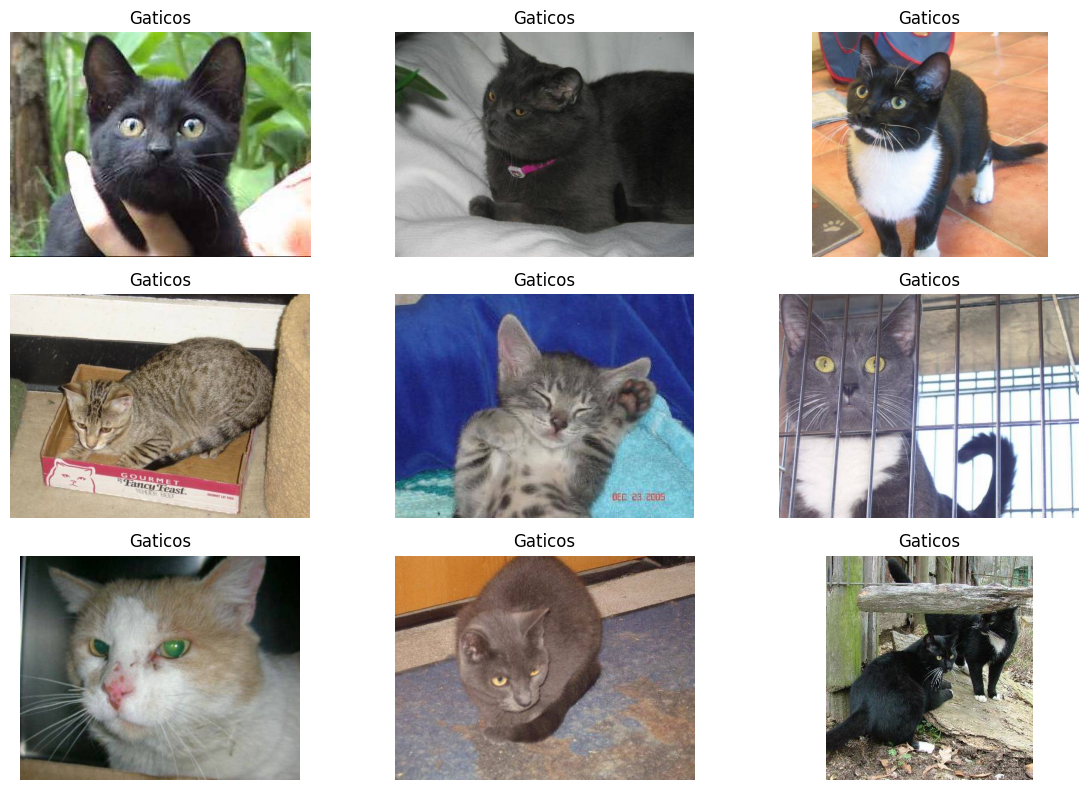

In [5]:
#Filtro
# Path
cat_dir = "../data/raw/train/cat"
cat_image_files = [f for f in os.listdir(cat_dir) if f.startswith("cat")]

cat_images = []
for i in range(min(9, len(cat_image_files))):  #Control numeración imagenes
    img_path = os.path.join(cat_dir, cat_image_files[i])
    img = image.load_img(img_path)  # Carga
    img_array = image.img_to_array(img) / 255.0  # Conversion a array
    cat_images.append(img_array)


plt.figure(figsize=(12, 8))
for i in range(len(cat_images)):
    plt.subplot(3, 3, i + 1)
    plt.imshow(cat_images[i])
    plt.title("Gaticos")
    plt.axis("off")

plt.tight_layout()
plt.show()

### Crear los datasets de las imagenes de perros y gatos

In [6]:
import numpy as np
import tensorflow as tf
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # Oculta warnings 

train_dir = "../data/raw/train"
tamano = (200, 200)
batch_size = 128 

# Obtener las rutas de las imágenes y las etiquetas
image_files = []
labels = []

for label, class_name in enumerate(['cat', 'dog']):
    class_dir = os.path.join(train_dir, class_name)
    for file in os.listdir(class_dir):
        if file.endswith(".jpg") or file.endswith(".png"):
            image_files.append(os.path.join(class_dir, file))
            labels.append(label)

# Convertir a arrays de numpy
labels = np.array(labels)

# Mezclar los datos
indices = np.arange(len(image_files))
np.random.shuffle(indices)
image_files = np.array(image_files)[indices]
labels = labels[indices]

class ImageDataLoader(tf.keras.utils.Sequence):
    def __init__(self, image_files, labels, batch_size, target_size):
        self.image_files = image_files
        self.labels = labels
        self.batch_size = batch_size
        self.target_size = target_size

    def __len__(self):
        return int(np.ceil(len(self.image_files) / self.batch_size))  # Número total de lotes

    def __getitem__(self, idx):
        batch_files = self.image_files[idx * self.batch_size:(idx + 1) * self.batch_size]
        batch_labels = self.labels[idx * self.batch_size:(idx + 1) * self.batch_size]

        images = []
        for file in batch_files:
            img = tf.keras.preprocessing.image.load_img(file, target_size=self.target_size)
            img_array = tf.keras.preprocessing.image.img_to_array(img) / 255.0  # Normalización
            images.append(img_array)

        return np.array(images), np.array(batch_labels)

# Crear generador de datos
train_generator = ImageDataLoader(image_files, labels, batch_size, tamano)

# Verificar los primeros 3 lotes
for i in range(3):
    batch_images, batch_labels = train_generator[i]
    print(f"Lote {i+1}: {batch_images.shape} imágenes, {batch_labels.shape} etiquetas")
    print(f"Primeras 10 etiquetas del lote {i+1}: {batch_labels[:10]}")


Lote 1: (128, 200, 200, 3) imágenes, (128,) etiquetas
Primeras 10 etiquetas del lote 1: [1 1 0 0 1 1 1 0 1 1]
Lote 2: (128, 200, 200, 3) imágenes, (128,) etiquetas
Primeras 10 etiquetas del lote 2: [1 0 0 0 1 1 1 0 1 1]
Lote 3: (128, 200, 200, 3) imágenes, (128,) etiquetas
Primeras 10 etiquetas del lote 3: [1 1 1 0 1 1 0 0 1 1]


## Modelado y entrenamiento

In [8]:
import keras_tuner as kt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
import numpy as np
import os

# Definir la función de creación del modelo para KerasTuner
def build_model(hp):
    model = Sequential()
    
    # Añadir capas convolucionales y de pooling
    model.add(Conv2D(
        hp.Int('filters', min_value=32, max_value=32, step=32), 
        kernel_size=(3, 3), 
        activation='relu', 
        input_shape=(200, 200, 3)
    ))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Conv2D(
        hp.Int('filters', min_value=32, max_value=32, step=32),
        kernel_size=(3, 3),
        activation='relu'
    ))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    
    # Capa densa
    model.add(Dense(
        hp.Int('dense_units', min_value=64, max_value=64, step=64), 
        activation='relu'
    ))
    
    model.add(Dense(1, activation='sigmoid'))  # Para clasificación binaria
    
    # Compilar el modelo
    model.compile(
        optimizer=Adam(learning_rate=hp.Float('learning_rate', min_value=0.001, max_value=0.01, step=0.001)),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    
    return model

# Usar KerasTuner para la búsqueda de hiperparámetros
tuner = kt.Hyperband(
    build_model,
    objective='val_accuracy',
    max_epochs=10,
    factor=3,
    directory='kt_dir',
    project_name='hyperparameter_tuning'
)

# Crear un generador para validación
val_generator = ImageDataLoader(image_files[:len(image_files)//5], labels[:len(labels)//5], batch_size, tamano)

# Crear un generador para entrenamiento
train_generator = ImageDataLoader(image_files[len(image_files)//5:], labels[len(labels)//5:], batch_size, tamano)

# Realizar la búsqueda de hiperparámetros
tuner.search(train_generator, epochs=10, validation_data=val_generator)

# Mostrar los mejores hiperparámetros encontrados
best_hyperparameters = tuner.oracle.get_best_trials(num_trials=1)[0].hyperparameters
print(f"Mejores hiperparámetros: {best_hyperparameters.values}")

Reloading Tuner from kt_dir/hyperparameter_tuning/tuner0.json

Search: Running Trial #6

Value             |Best Value So Far |Hyperparameter
64                |32                |filters
128               |64                |dense_units
0.001             |0.002             |learning_rate
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
2                 |2                 |tuner/bracket
0                 |0                 |tuner/round



2025-03-04 16:04:58.882192: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


Epoch 1/2


2025-03-04 16:04:59.702581: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


: 

In [ ]:
from scikeras.wrappers import KerasClassifier

model = KerasClassifier(build_fn=create_model, verbose=0)